In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from pathlib import Path
import json
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.metrics import root_mean_squared_error
import joblib
import seaborn as sns

In [2]:
# Load annotations for training
train_ann_path = Path('./Data/coco2017/annotations/person_keypoints_train2017.json')
with open(train_ann_path, 'r') as f:
	data = json.load(f)

# Only keep keypoint annotations
annotations = data['annotations']

In [3]:
keypoints = []
for i in range(len(annotations)):
	img_keypoints = annotations[i]["keypoints"] # Keypoints for 1 image

	# Each person has 17 keypoints, 3 values for each
	# (x, y, visibility_flag)
	keypoints.append([])
	for j in range(0, len(img_keypoints), 3):
		keypoints[i].append(img_keypoints[j:j+3])

torch.tensor(keypoints).shape

torch.Size([262465, 17, 3])

In [4]:
train_inputs = []
train_targets = []

# Only keep shoulders, hips, and feet
# Indices for inputs
input_indices = [5, 6, 11, 12] # Left Shoulder, Right Shoulder, Left Hip, Right Hip
# Indices for targets
target_indices = [15, 16] # Left Foot (Ankle), Right Foot (Ankle)

for i in range(len(keypoints)):
	points = np.array(keypoints[i])[input_indices]
	if points[0][2] == 0 or points[1][2] == 0 or points[2][2] == 0 or points[3][2] == 0:
		continue

	label = np.array(keypoints[i])[target_indices]
	if label[0][2] == 0 or label[1][2] == 0:
		continue

	train_inputs.append(points)
	train_targets.append(label)

torch.tensor(train_inputs).shape, torch.tensor(train_targets).shape

C:\Users\tshar\AppData\Local\Temp\ipykernel_45816\1065122196.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  torch.tensor(train_inputs).shape, torch.tensor(train_targets).shape


(torch.Size([61720, 4, 3]), torch.Size([61720, 2, 3]))

In [5]:
train_inputs[0], train_targets[0]

(array([[198, 193,   2],
        [243, 196,   2],
        [197, 298,   2],
        [228, 297,   2]]),
 array([[205, 475,   2],
        [215, 453,   2]]))

In [6]:
# Load keypoints for testing
test_ann_path = Path('./Data/coco2017/annotations/person_keypoints_val2017.json')
with open(test_ann_path, 'r') as f:
	data = json.load(f)

test_annotations = data['annotations']
keypoints = []
for i in range(len(annotations)):
	img_keypoints = annotations[i]["keypoints"] # Keypoints for 1 image

	# Each person has 17 keypoints, 3 values for each
	# (x, y, visibility_flag)
	keypoints.append([])
	for j in range(0, len(img_keypoints), 3):
		keypoints[i].append(img_keypoints[j:j+3])

test_inputs = []
test_targets = []

# Only keep shoulders, hips, and feet
# Indices for inputs
input_indices = [5, 6, 11, 12] # Left Shoulder, Right Shoulder, Left Hip, Right Hip
# Indices for targets
target_indices = [15, 16] # Left Foot (Ankle), Right Foot (Ankle)

for i in range(len(keypoints)):
	points = np.array(keypoints[i])[input_indices]
	if points[0][2] == 0 or points[1][2] == 0 or points[2][2] == 0 or points[3][2] == 0:
		continue

	label = np.array(keypoints[i])[target_indices]
	if label[0][2] == 0 or label[1][2] == 0:
		continue

	test_inputs.append(points)
	test_targets.append(label)

torch.tensor(test_inputs).shape, torch.tensor(test_targets).shape

(torch.Size([61720, 4, 3]), torch.Size([61720, 2, 3]))

In [7]:
test_inputs[0], test_targets[0]

(array([[198, 193,   2],
        [243, 196,   2],
        [197, 298,   2],
        [228, 297,   2]]),
 array([[205, 475,   2],
        [215, 453,   2]]))

In [8]:
# Dataset
class CocoKeypoints(Dataset):
	def __init__(self, inputs, labels):
		super(CocoKeypoints, self).__init__()
		self.inputs = torch.tensor(inputs, dtype=torch.float32)
		self.labels = torch.tensor(labels, dtype=torch.float32)

	def __len__(self):
		return len(self.labels)

	def __getitem__(self, index):
		# Remove visibility from keypoints
		return self.inputs[index].T[:2].T.flatten(), self.labels[index].T[:2].T.flatten()

In [9]:
BATCH_SIZE = 8
NUM_WORKERS = 0

# Data loader
train = CocoKeypoints(train_inputs, train_targets)
test = CocoKeypoints(test_inputs, test_targets)

train_loader = DataLoader(train, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test, batch_size=BATCH_SIZE,
                         shuffle=True, num_workers=NUM_WORKERS)

In [10]:
train[0]

(tensor([198., 193., 243., 196., 197., 298., 228., 297.]),
 tensor([205., 475., 215., 453.]))

# Linear Regression Model

In [11]:
# Prepare data for LinearRegression
train_inputs_flat = [train_inputs[index].T[:2].T.flatten() for index in range(len(train_inputs))]
train_targets_flat = [train_targets[index].T[:2].T.flatten() for index in range(len(train_targets))]

test_inputs_flat = [test_inputs[index].T[:2].T.flatten() for index in range(len(test_inputs))]
test_targets_flat = [test_targets[index].T[:2].T.flatten() for index in range(len(test_targets))]

# Create and train the model
lin_reg_model = LinearRegression()
lin_reg_model.fit(train_inputs_flat, train_targets_flat)

# Make predictions on the test set
predictions = lin_reg_model.predict(test_inputs_flat)

# Evaluate the model
mse = root_mean_squared_error(test_targets_flat, predictions)
print(f'Mean Squared Error: {mse}')

# Save the model
joblib.dump(lin_reg_model, "./Models/LinearRegression_FeetPredict.pkl")

Mean Squared Error: 32.669257493680284


['./Models/LinearRegression_FeetPredict.pkl']

# Pytorch model

In [12]:
class KeypointPredictor(nn.Module):
	def __init__(self):
		super(KeypointPredictor, self).__init__()
		self.seq = nn.Sequential(
			nn.Linear(8, 4)
		)

	def forward(self, x):
		return self.seq(x)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = KeypointPredictor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = nn.MSELoss()

In [14]:
def train(epoch, train_losses):
	running_loss = 0.0
	model.train()
	loop = tqdm(train_loader, leave=False, desc=f"Epoch {epoch}")
	for data, target in loop:
		data, target = data.to(device), target.to(device)
		results = model(data)  # Forward pass
		optimizer.zero_grad()
		loss = loss_fn(results, target)
		loss.backward()  # Back propogation
		optimizer.step()
		loop.set_postfix(loss=loss.item())
		running_loss += loss.item()
		
	train_losses.append(running_loss / len(train_loader.dataset))

def test(test_losses):
	model.eval()
	test_loss = 0
	with torch.inference_mode():
		for data, target in test_loader:
			data, target = data.to(device), target.to(device)
			results = model(data)
			test_loss += loss_fn(results, target).item()

	test_loss /= len(test_loader.dataset)
	print(f"Test Loss {test_loss}")

	test_losses.append(test_loss)

In [15]:
train_losses = []
test_losses = []

In [16]:
epochs = 5

for epoch in range(1, epochs + 1):
	train(epoch, train_losses)
	test(test_losses)
	# if test_loss is minimum, save the model
	if test_losses[-1] <= min(test_losses) and test_losses[-1] < 145.32:
		torch.save(model.state_dict(), "./Models/FeetPredict.pt")

Test Loss 145.22503746883172


Test Loss 141.34261502867307


Test Loss 139.64772389400184


Test Loss 138.7363729308197


Test Loss 139.35047854882745


# Plot results DL

<Axes: >

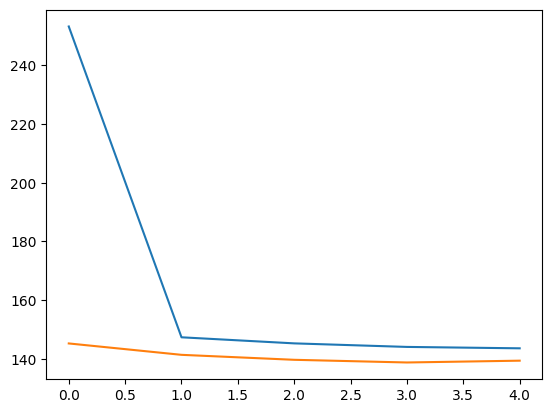

In [17]:
sns.lineplot(x=range(len(train_losses)), y=train_losses)
sns.lineplot(x=range(len(test_losses)), y=test_losses)